<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/text/tfidf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Train machine learning models for text classification using tf-idf  and see which features were important for prediction (feature importance)

There are many options to build machine learning (ML) models.

### Task:
- Classification: dependent variable (DV) is categorical (binary or multinomial)
- Regression: DV is ordinal or continuos.
Note: "logistic regression" is for classication tasks. 

More advanced modeling is generalized linear models, generalized additive models. 

### Feature extraction

When using text, audio, image data, you'll have to convert them into simpler vectors or matrices of numbers. Here we do tf-idf on text data. Deep learning tends to create features internally, so you don't have to create features. 

Next step could be to encode the documents with deep learning embeddings like BERT.


### Evaluation: 
- Train-test split: 80-20 or 70-30 is normal. 
- Cross-validation: better for smaller datasets because a single test set is not representative of the data. sampling without replacement (K disjoint sets of the data)
- Bootstrapping: sampling with replacement

Try train-test split, then learn about cross-validation. 

### Hyperparameter tuning: 
- You can create a validation set from the train set to see which hyperparameters perform best. You only test once at the end on the test set using the hyperparameters that performed best on the validatio set. 
- If doing Cross-validation. You can do nested cross-validation: a CV within each train set. 

Learn about gridsearch. 

### Feature importance
- Which variables are important for prediction? The method to answer this depends on the model used. Here is an overview for simple models: 
https://machinelearningmastery.com/calculate-feature-importance-with-python/

SHAP, permutation importance, and LOFO work for any model. 

Book on the topic:
https://christophm.github.io/interpretable-ml-book/




In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import fetch_20newsgroups,fetch_california_housing
from sklearn.model_selection import cross_validate
# from sklearn.metrics import make_scorer, f1_score,precision_score,recall_score,accuracy_score, classification_report
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, recall_score, f1_score, precision_score, ConfusionMatrixDisplay, precision_recall_curve, auc
import datetime



In [9]:
# load dataset
pd.set_option("display.max_columns", None)
# pd.options.display.width = 0


on_colab = False

if on_colab:
    from google.colab import drive
    project_name = 'project_name'
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/final_datasets/'
    output_dir = './data/output/performance/tfidf/'

os.makedirs(output_dir,exist_ok=True)    
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')
ts

'23-08-03T19-21-52'

In [91]:
# load data
train = pd.read_csv(input_dir+'train.csv', index_col=0)
val = pd.read_csv(input_dir+'val.csv', index_col=0)
test = pd.read_csv(input_dir+'test.csv', index_col=0)

X_train = train['content'].values
y_train = train['label'].values
X_val = val['content'].values
y_val = val['label'].values
X_test = test['content'].values
y_test = test['label'].values



In [12]:
# config. This section should be the only place where people change things
cv = 5 # 5, 7 or 10 or typical values
stop_words = 'english' # or None
task = 'classification' # or 'regression'


In [53]:
# !pip install -q -U imbalanced-learn

In [99]:
y_train

array([0., 0., 1., ..., 0., 0., 0.])

In [100]:
X_new, y_new = RandomUnderSampler.fit_resample(X = X_train, y= y_train)

TypeError: fit_resample() missing 1 required positional argument: 'self'

In [124]:
from lightgbm import LGBMClassifier

In [130]:

if task == 'classification':
  models = [
      LogisticRegression(),
      LGBMClassifier()
      # SVC(kernel='linear', class_weight='balanced', probability=True), 
            ]
elif task == 'regression':
  # ToDo: find equivalent model in sklearn but for regression
  pass 

# feature extractor
vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), max_df=0.9, min_df=3, max_features=None)


from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=random_state)
under = RandomUnderSampler(random_state=random_state)

from imblearn.over_sampling import SMOTE
random_state = 123
methods = [
    smote,
    under
]

# X_y_train_balanced = {}
# for method_i in methods:
#     X_y_train_balanced[method_i] = [method_i.XXXXXX(X_train, y_train)]



from imblearn.pipeline import Pipeline as imb_Pipeline

pipelines = {}
for model in models:
    model_name = str(model).split('(')[0] # eg, LogisticRegression
    # pipe = make_pipeline(
    #     vectorizer,
    #     RandomUnderSampler(random_state=123),
    #     model,
    # )

    pipe = imb_Pipeline([
     ('vectorizer', vectorizer),
     ('balancer', SMOTE(random_state=random_state)),
     ('model', model),
    ])


    
        
    # sklearn    
    # pipe = Pipeline(
    #   [
    #       ("vectorizer",vectorizer),
    #       ("balancer", under),
    #       ("model", model)
    #   ])
    
    pipelines[model_name] = pipe

# param_grid = {
#     'balancer': [None, SMOTE(), RandomUnderSampler()],
#     'vectorizer__max_features': [None, 10000],
# }
# pipeline gridsearch: https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html



In [131]:
from sklearn.model_selection import GridSearchCV

In [132]:
# param_grid = {

#     'preprocessor__text__vectorizer__max_features': [2000, None],
#     'lgbm__colsample_bytree': [1, 0.5, 0.1],
#     'lgbm__max_depth': [-1,10,40], #-1 is the default and means No max depth
#     'lgbm__min_child_weight': [0.01, 0.001, 0.0001],
#     'lgbm__min_child_samples': [20,40], #alias: min_data_in_leaf
    
# }

# grid_search = GridSearchCV(
#     pipe, tuned_parameters, scoring=scores, refit=refit_strategy
# )
# grid_search.fit(X_train, y_train)

#In order to prevent data leakage during hyperparameter tuning with the meta data, hard code the splits for cross validation
#instead of using sklearn GridSearchCV
# grid_search_train, grid_search_indices = get_cross_valid_dataset(train,val)
# grid_search_train

# text_grid_search = GridSearchCV(pipe, param_grid, scoring=["average_precision", "f1", "recall", "precision"], refit="f1", n_jobs=-1)
# text_grid_search
# text_grid_search.fit(grid_search_train, grid_search_train['label'])

In [133]:
pipelines.items()

dict_items([('LogisticRegression', Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('balancer', SMOTE(random_state=123)),
                ('model', LogisticRegression())])), ('LGBMClassifier', Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('balancer', SMOTE(random_state=123)),
                ('model', LGBMClassifier())]))])

In [134]:
# for model_name, pipeline in pipelines.items():
#   print(model_name)
#   display(pipeline)
#   print()

# Train and evaluate model

In [135]:
output_dir

'./data/output/performance/tfidf/'

LogisticRegression
LGBMClassifier
done


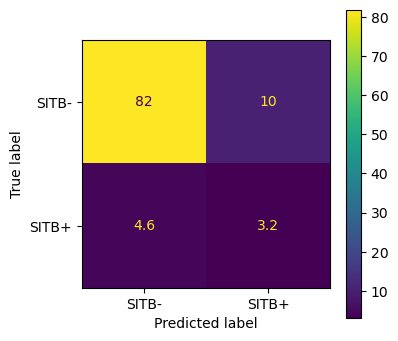

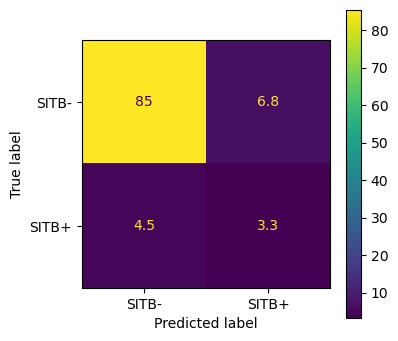

In [136]:
import metrics_report

from importlib import reload
reload(metrics_report)


# scoring: https://scikit-learn.org/stable/modules/model_evaluation.html

results = {}
for model_name, pipe in pipelines.items():
    print(model_name)
    output_dir_i = output_dir+model_name+'/'
    os.makedirs(output_dir_i,exist_ok=True)
    # y_pred = pipe.fit(X_train, y_train) #train
    y_pred_proba = pipe.predict_proba(X_val)

    y_pred_proba_1 = y_pred_proba[:,1]
    y_pred = [np.argmax(n) for n in y_pred_proba]
    clf_report_sklearn = classification_report(y_val,y_pred, output_dict=False) #evaluate #different than the output of cross_validate() above.
    cm_df_meaning, cm_df, cm_df_norm = metrics_report.cm(y_val, y_pred, output_dir_i, model_name, ts, save=True)
    clf_report = metrics_report.classification_report(y_val, y_pred,y_pred_proba_1, output_dir_i, model_name, ts)
    # scores = cross_validate(pipe, X, y, scoring=['f1','precision', 'recall'], cv=cv, return_train_score=False) #train and evaluate    
    results[model_name] = {
        'clf_report': clf_report,
        'cm_df_meaning': cm_df_meaning,
        'cm_df': cm_df,
        'cm_df_norm': cm_df_norm,
        'clf_report_sklearn': clf_report_sklearn

    }

print('done')

        

In [137]:
pipelines.items()

dict_items([('LogisticRegression', Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('balancer', SMOTE(random_state=123)),
                ('model', LogisticRegression())])), ('LGBMClassifier', Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('balancer', SMOTE(random_state=123)),
                ('model', LGBMClassifier())]))])

In [141]:
print(results['LogisticRegression'].get('clf_report_sklearn'))

              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       638
         1.0       0.23      0.41      0.30        54

    accuracy                           0.85       692
   macro avg       0.59      0.65      0.61       692
weighted avg       0.89      0.85      0.87       692



In [64]:
results['SVC'].get('clf_report')


KeyError: 'SVC'

In [54]:
score_names = ['f1-score','precision', 'recall']
df_results = pd.DataFrame(np.zeros(((len(results.keys())),len(score_names))),index = results.keys(), columns = score_names) # fill with zeros

for model_name in results.keys():
    scores = results.get(model_name)
    if cv_or_traintest == 'cv':
      for s in score_names:
        if s == 'f1-score':
          s = 'f1' # this is how it is saved in cross_validation()
        mean_score = np.round(np.mean(scores.get(s)),2)
        sd = np.round(np.std(scores.get(s)),2)
        df_results.loc[model_name,s] = f'{mean_score} ({sd})'
    elif cv_or_traintest == 'traintest':
      for s in score_names:
        score = np.round(scores.get('macro avg').get(s),2)
        df_results.loc[model_name,s] = f'{score}'

df_results


,f1-score,precision,recall
LogisticRegression,0.98,0.98,0.98
SVC,0.98,0.98,0.98


# Get important features for any pipeline or feature union
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214


In [9]:
# Fit a specific model to entire data

import matplotlib.pyplot as plt
import seaborn as sns

pipe = Pipeline(
    [
        ("vectorizer", vectorizer),
        ("model", LogisticRegression(class_weight='balanced')),
    ]
    )

pipe.fit(X,y)


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('model', LogisticRegression(class_weight='balanced'))])

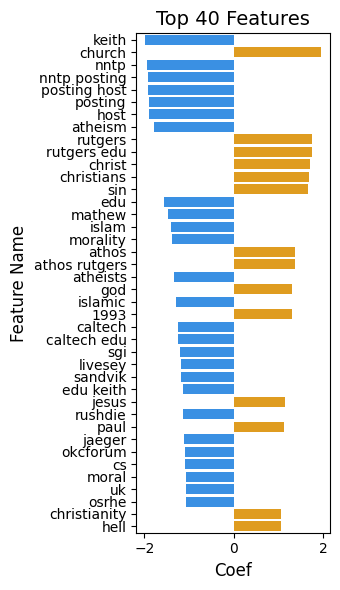

In [19]:
top_k = 40


feature_names = pipe.named_steps["vectorizer"].get_feature_names_out()

# Get the coefficients of each feature
coefs = pipe.named_steps["model"].coef_.flatten()

# Visualize feature importances
# Sort features by absolute value
df = pd.DataFrame(zip(feature_names, coefs), columns=["feature", "value"])
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "orange" if x > 0 else "dodgerblue")
df = df.sort_values("abs_value", ascending=False)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 6))
sns.barplot(x="value",
            y="feature",
            data=df.head(top_k),
           palette=df.head(top_k)["colors"])
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_title(f"Top {top_k} Features", fontsize=14)
ax.set_xlabel("Coef", fontsize=12) # coeficient from linear model
ax.set_ylabel("Feature Name", fontsize=12)
plt.tight_layout()
# plt.savefig(output_dir+f'top_{top_k}_features_{y_name}.png', dpi=300)